# <font color = 'blue'> I.BUSINESS UNDERSTANDING
<font color = 'blue'>Real estate has traditionally been a staple asset for investors that offer potential benefits such as excellent cash flow and diversification of asset portfolios.  When well-chosen, real estates typically appreciate in value over time, thus providing protection against inflation.  For these reasons, data on real estate pricings based listings of properties for sale are collected because they useful to potential investors.  These listings can be used as a starting basis for property valuation given specific group(s) of features.  

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pandas import set_option
set_option('display.max_columns',400)
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import scipy

In [2]:
# Import libraries for clustering

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as mt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.express as px

# <font color = 'blue'> II.DATA UNDERSTANDING
<font color = 'blue'>A.Meaning and Type of Data for Attributes: Property_type and Country

<font color = 'blue'>B.Data Quality: 

<font color= 'blue'>Outliers:  Outliers were included in the analysis because the dataset has over 400,000 entries, thus making any one outlier's effect on the data minimal.

<font color = 'blue'>Missing Values:  the final dataset used in cluster analysis was an imputed dataset using XXXX values for each attribute with missing data.


In [3]:
# Read in the imputed dataset

# Tom
df = pd.read_csv('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Imputed_Dataset.csv', sep = ',', header = 0)

#Quynh
#df = pd.read_csv('Imputed_Dataset.csv', sep = ',', header = 0)

# Anish
#df = pd.read_csv('filepath, sep = ',', header = 0)

# Michael
#df = pd.read_csv('filepath', sep = ',', header = 0)

# Drop index column
df = df.drop(columns = 'Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463724 entries, 0 to 463723
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              409210 non-null  float64
 1   lon              409210 non-null  float64
 2   rooms            463724 non-null  float64
 3   bedrooms         463724 non-null  float64
 4   bathrooms        463724 non-null  float64
 5   surface_total    463724 non-null  float64
 6   surface_covered  463724 non-null  float64
 7   price            463723 non-null  float64
 8   log_price        463724 non-null  float64
 9   id               463723 non-null  object 
 10  start_date       463723 non-null  object 
 11  end_date         463723 non-null  object 
 12  created_on       463723 non-null  object 
 13  property_type    463723 non-null  object 
 14  l1               463723 non-null  object 
 15  l2               463723 non-null  object 
 16  l3               441216 non-null  obje

In [4]:
# Remove some outliers (surface_covered) to improve normalization results and allow better visualization
# Define Function for removing outliers of numeric columns 
def remove_outlier(df):
    i = []
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    df.loc[(df['surface_covered'] < quant_df.loc[high, 'surface_covered']), 'keep'] = 1
    df.loc[(df['surface_covered'] >= quant_df.loc[high, 'surface_covered']), 'keep'] = 0
    # This next row also removes surface total outliers
    df.loc[(df['surface_total'] >= quant_df.loc[high, 'surface_total']), 'keep'] = 0
    df = df[df.keep == 1]
        
    #df = df[(df['surface_covered'] < quant_df.loc[high, 'surface_covered'])]
    return df

In [5]:
# Remove outliers and recast data for plotting
df = remove_outlier(df)
df.reset_index(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427265 entries, 0 to 427264
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   index            427265 non-null  int64  
 1   lat              378101 non-null  float64
 2   lon              378101 non-null  float64
 3   rooms            427265 non-null  float64
 4   bedrooms         427265 non-null  float64
 5   bathrooms        427265 non-null  float64
 6   surface_total    427265 non-null  float64
 7   surface_covered  427265 non-null  float64
 8   price            427264 non-null  float64
 9   log_price        427265 non-null  float64
 10  id               427264 non-null  object 
 11  start_date       427264 non-null  object 
 12  end_date         427264 non-null  object 
 13  created_on       427264 non-null  object 
 14  property_type    427264 non-null  object 
 15  l1               427264 non-null  object 
 16  l2               427264 non-null  obje

In [32]:
# Reformat attributes, excluding categoricals, which aren't supported for the the dummy variable generation method used.
ordinal_vars = ['rooms', 'bedrooms', 'bathrooms' ]
continuous_vars = ['lat', 'lon', 'surface_total', 'surface_covered', 'price', 'log_price']
string_vars = ['id', 'title', 'description','property_type', 'l1','description']
time_vars = ['start_date', 'end_date', 'created_on']

# Change data types
df[ordinal_vars] = df[ordinal_vars].astype('uint8')
df[continuous_vars] = df[continuous_vars].astype(np.float64)
df[string_vars] = df[string_vars].astype(str)

# Remove observations missing l3 and price before encoding 
df2 = df.dropna(axis = 0, subset = ['price', 'l3'])

# Create dataset using numeric attributes, property type and country, make classification variable ordinal
df_num = df.copy()
#df_num.loc[(df_num['price_class'] == 'Low'), 'price_class_final'] = 0
#df_num.loc[(df_num['price_class'] == 'Average'), 'price_class_final'] = 1
#df_num.loc[(df_num['price_class'] == 'High'), 'price_class_final'] = 2

df_num = df_num[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'log_price', 'property_type','l1', 'price_class']]
df_num = df_num.dropna()

In [33]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427264 entries, 0 to 427263
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   rooms            427264 non-null  uint8  
 1   bedrooms         427264 non-null  uint8  
 2   bathrooms        427264 non-null  uint8  
 3   surface_total    427264 non-null  float64
 4   surface_covered  427264 non-null  float64
 5   price            427264 non-null  float64
 6   log_price        427264 non-null  float64
 7   property_type    427264 non-null  object 
 8   l1               427264 non-null  object 
 9   price_class      427264 non-null  object 
dtypes: float64(4), object(3), uint8(3)
memory usage: 27.3+ MB


<font color = 'blue'>C. Visualization of Important Attributes

We will create multiple visualizations to explore the potential of clustering for our dataset. We foresee clustering as a useful way to impute missing data, and possibly as an effective alternative to price-classification. These visualizations include 3D Scatterplots, ...,

In [ ]:
# 3D Scatter plot
import plotly.express as px
fig = px.scatter_3d(df_num, x = 'rooms', y = 'surface_covered', z = 'log_price', color = 'l1', size = 'bathrooms')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

The clustering for each country seem to have a roughly common center, differing only slightly in the distribution of noise points. Clustering wouldn't likely be helpful classifying country on these attributes. We will explore a few more combinations.

In [ ]:
# Plot rooms, surface_covered, surface_total
fig = px.scatter_3d(df_num, x = 'rooms', y = 'surface_covered', z = 'surface_total', color = 'l1', size = 'bathrooms')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

Use latitude and longitude to cluster country.

In [10]:
## Reformat attributes, excluding categoricals, which aren't supported for the the dummy variable generation method used.
# ordinal_vars = ['rooms', 'bedrooms', 'bathrooms' ]
# continuous_vars = ['lat', 'lon', 'surface_total', 'surface_covered', 'price', 'log_price']
# string_vars = ['id', 'title', 'description','property_type', 'l1','description']
# time_vars = ['start_date', 'end_date', 'created_on']

# # Change data types
# df[ordinal_vars] = df[ordinal_vars].astype('uint8')
# df[continuous_vars] = df[continuous_vars].astype(np.float64)
# df[string_vars] = df[string_vars].astype(str)

# Remove observations missing l3 and price before encoding 
df2 = df.dropna(axis = 0, subset = ['price', 'l3'])

# Create dataset using numeric attributes, property type and country, make classification variable ordinal
df_latlon = df.copy()
#df_num.loc[(df_num['price_class'] == 'Low'), 'price_class_final'] = 0
#df_num.loc[(df_num['price_class'] == 'Average'), 'price_class_final'] = 1
#df_num.loc[(df_num['price_class'] == 'High'), 'price_class_final'] = 2

df_latlon = df_latlon[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'log_price', 'property_type','l1', 'lat', 'lon']]
df_latlon = df_latlon.dropna()

In [12]:
df_latlon.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,log_price,property_type,l1,lat,lon
2,7,3,2,173.0,173.0,195000.0,12.180755,Casa,Argentina,-27.371199,-55.898454
4,3,3,1,49.0,40.0,85000.0,11.350407,Casa,Argentina,-32.951146,-60.571979
5,4,3,3,400.0,400.0,570000.0,13.253392,Casa,Argentina,-32.961060,-68.877991
6,4,2,3,193.0,175.0,935000.0,13.748302,Departamento,Argentina,-34.572445,-58.420624
7,2,2,1,31.0,31.0,89000.0,11.396392,Departamento,Argentina,-34.578547,-58.430038


In [ ]:
# Plot lat, lon, country color by property type
fig = px.scatter_3d(df_latlon, x = 'lat', y = 'lon', z = 'l1', color = 'property_type', size = 'rooms', 
                    title = 'Country Clustering by Latitude and Longitude')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

The plot above shows that latitude and longitude could effectively be used to impute an observation's country value in case of missing data. It appears that Ecuador may prove tricky using clustering since it is equidistant between Peru and Colombia, and has few data points. We may want to extend this analysis to a larger subset of the data. This method extends to imputing missing l2 (province) and l3 (department) values as well. If we wanted to include department in the model, this would be worth pursuing.

In [34]:
# Create a temporary dataframe for data exploration
# Create a surface_covered/surface_total ratio variable
df_tmp = df.copy()
df_tmp['surface_ratio'] = df_tmp['surface_covered'] / df_tmp['surface_total']

df_tmp = df_tmp[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'log_price', 'property_type','l1', 'price_class', 'lat', 'lon', 'surface_ratio']]
df_tmp = df_tmp.dropna()
df_tmp

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,log_price,property_type,l1,price_class,lat,lon,surface_ratio
2,7,3,2,173.0,173.0,195000.0,12.180755,Casa,Argentina,Average,-27.371199,-55.898454,1.000000
4,3,3,1,49.0,40.0,85000.0,11.350407,Casa,Argentina,Low,-32.951146,-60.571979,0.816327
5,4,3,3,400.0,400.0,570000.0,13.253392,Casa,Argentina,High,-32.961060,-68.877991,1.000000
6,4,2,3,193.0,175.0,935000.0,13.748302,Departamento,Argentina,High,-34.572445,-58.420624,0.906736
7,2,2,1,31.0,31.0,89000.0,11.396392,Departamento,Argentina,Low,-34.578547,-58.430038,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427259,5,2,1,214.0,107.0,129000.0,11.502875,Departamento,Uruguay,Average,-34.908546,-56.187075,0.500000
427260,2,2,1,63.0,62.0,210000.0,11.767568,Departamento,Uruguay,High,-34.907481,-56.187290,0.984127
427261,4,2,2,255.0,128.0,150000.0,12.254863,Otro,Uruguay,Low,-34.908144,-56.197043,0.501961
427262,4,3,2,114.0,114.0,98500.0,11.918391,Departamento,Uruguay,Average,-34.879144,-56.178020,1.000000


In [ ]:
# Explore price, log_price, and property type
fig = px.scatter_3d(df_tmp, x = 'price', y = 'log_price', z = 'property_type', color = 'price_class', 
                    title = 'Country Clustering by Latitude and Longitude')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

In [ ]:
# Explore log_price, rooms, and property type
fig = px.scatter_3d(df_tmp, x = 'rooms', y = 'log_price', z = 'property_type', color = 'price_class', 
                    title = 'Country Clustering by Latitude and Longitude')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

No handles with labels found to put in legend.


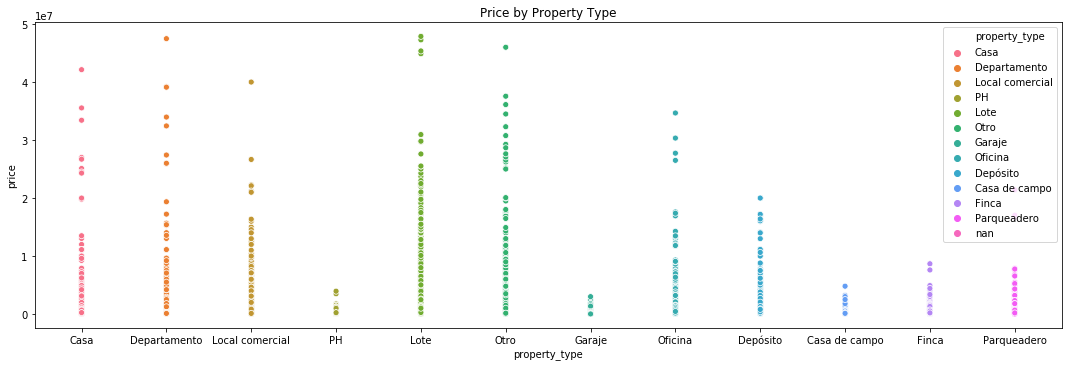

In [25]:
#Plot the dataset: price vs. property_type
import seaborn as sns
plt.figure(figsize=(15,5))
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Price by Property Type")
plt.tight_layout()
plt.savefig("Price_by_PropertyType_Feature.png",
                    format='png',dpi=150)
sns.scatterplot('property_type', 'price', data=df, hue='property_type')
plt.show()

No handles with labels found to put in legend.


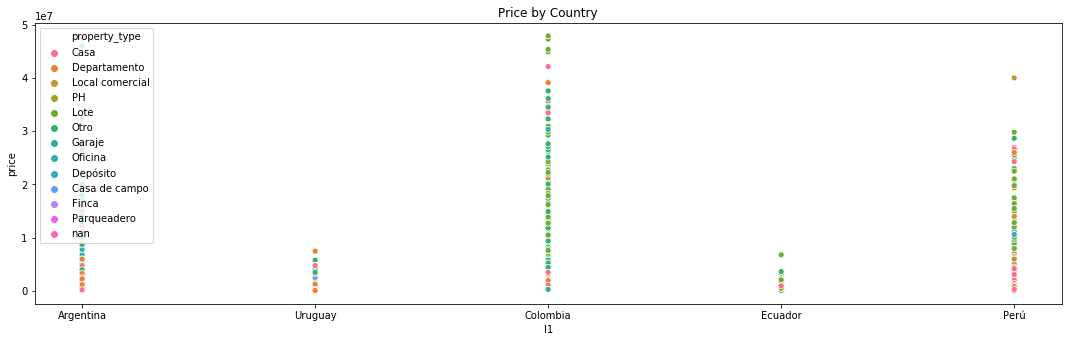

In [31]:
#Plot the Dataset on Property Type
import seaborn as sns
plt.figure(figsize=(15,5))
plt.legend(bbox_to_anchor=(1.01, 1.15),borderaxespad=0)
plt.title("Price by Country")
plt.tight_layout()
plt.savefig("Price_by_Country_by_PropertyType_Feature.png",
                    format='png',dpi=150)
sns.scatterplot('l1', 'price', data=df, hue='property_type')
plt.show()

Create a transformed dataset with numeric variables square-root transformed to better meet model assumptions of feature distributions. This reduces the number and magnitude of outliers. In addition to this, both datasets will have the property_type, country, province, and department dummified, and all other attributes will be scaled. Both the transformed and non-transformed datasets will be used to create competing models.

In [6]:
# Get dummy variables for non-transformed dataset
data = pd.get_dummies(df_num, columns = ['l1', 'property_type'], 
                      prefix = {'l1':'Country', 'property_type': 'Property_type'}, 
                      sparse = True, drop_first = False)

# Drop reference levels for each dummified feature and unimportant or currently unusable features. 
data = data.drop(columns = ['Country_Argentina', 'Property_type_Casa'])
data = data.drop(columns = ['id', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'title', 'description', 'price'])

# <font color = 'blue'>III. MODELING AND EVALUATION: CLUSTER ANALYSIS - Train and Adjust Parameters




# <font color = 'blue'>III. MODELING AND EVALUATION: CLUSTER ANALYSIS - Evaluate and Compare



# <font color = 'blue'>III. MODELING AND EVALUATION: CLUSTER ANALYSIS - Visualize Results



# <font color = 'blue'>III. MODELING AND EVALUATION: Summarize the Rammications from Cluster Analysis

# <font color = 'blue'>IV. Deployment
<font color = 'blue'>Our model can be used by potential investors wanting to do due diligence on properties for sale in South America.  In order to stay relevant, the model will need to be updated on a quarterly basis to reflect market fluctuations.  In addition, there is a high degree of data wrangling and preprocessing needed in terms of combining data sets from different countries and quality checks for missing or invalid data values.  Given this detailed maintenance and since regular updates are needed, a user subscription based deployment would be ideal to keep our model accurate and end-user friendly.

# <font color = 'blue'>V.  Exceptional Work


